# Upperair Observation Plotting

This notebook demonstrates reading surface data and plotting it using MetPy's declarative syntax.

To make a plot of surface observations requires three elements
* `PlotObs()` to specify the observations to be plotted
* `MapPanel()` to specify the characteristics of the map to plot the observations on
* `PanelContainer()` to collect one or more panels.

So we are using the same method to plot upperair observations that we used to plot surface observations: `declarative.PlotObs()`. If you need a refresher on how to set up the parameters for `PlotObs`, please refer to detailed description [here](../metpy_declarative_plotobs.md).

One of the main differences will be that we’ll need a different data source.

## Import Modules

Here we import two new pieces to help us read and process upperair observation data. A new function to help get us latitude and longitude points for each upperair observation station. This helper function comes from the I/O module in metpy and is named `add_station_lat_lon`. We'll also use a new library, [Siphon](https://unidata.github.io/siphon/latest/), to be able to access and read remote upperair observation data.

In [1]:
from datetime import datetime

from metpy.io import add_station_lat_lon
from metpy.plots import declarative
from metpy.units import units
from siphon.simplewebservice.iastate import IAStateUpperAir

## Read Data

There is an easy way to access upperair data from Iowa State that has data from 1974 to yesterday that is easily accessible in a Python framework. This requires a different Python module called Siphon (also developed by Unidata). With the use of functionality from Siphon, all we need to provide is the date and time (in UTC) for the observations we wish to obtain. So we can use our favoriate `datetime` module to specifically specify the year, month, day, and hour of our observations.

:::{note}
For upperair observations we *at most* have them only twice in a given day, at 00 UTC and 12 UTC. So you'll only want to put in an hour of `0` or `12` when accessing upperair observations.
:::

In [2]:
# Set date for desired UPA data
date = datetime(2021, 12, 31, 0)

# Request data using Siphon request for data from Iowa State Archive
df = IAStateUpperAir.request_all_data(date)

Now we need to process our data just a little bit. First we use our helper function to add station latitude and longitude values to our DataFrame, then we take out the station called 'KVER' because there is not an upperair station at that location (it is misidentified within the dataset).

In [6]:
# Add lat/long data and drop stations for which we don't have lat/lons
df = add_station_lat_lon(df, 'station').dropna(subset=['latitude', 'longitude'])

# Eliminate the station KVER
df = df[df.station != 'KVER']

In [7]:
# Print the list of variables available from the dataset.
print(list(df.columns))

['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed', 'station', 'time', 'u_wind', 'v_wind', 'latitude', 'longitude']


:::{note}
Assumed Upperair Observation Units:
`{'pressure': 'hPa',
 'height': 'meter',
 'temperature': 'degC',
 'dewpoint': 'degC',
 'direction': 'degrees',
 'speed': 'knot',
 'u_wind': 'knot',
 'v_wind': 'knot',
 'station': None,
 'time': None}`
 :::

### Calculate Dewpoint Depression

Dewpoint depression (DD) is a quantity that needs to be calculated from the temperature and dewpoint at each observation point. The calculation is simple,

DD = Temperature - Dewpoint

and then we just need to save the difference to a new variable name and store within our DataFrame.

In [8]:
df['dewpoint_depression'] = df['temperature'] - df['dewpoint']

## Plot Upperair Map

Now that we have our data, we are ready to go about plotting it on a map.

Here we demonstrate our use of the Lambert Conic Conformal projection that has been incorporated into the declarative syntax, `'lcc'`. Additionally, we'll use a `lambda` to format the heights into the appropriate three-digit format and set an appropriate extent in the for the map we are desiring to plot.

### Formatting Heights
As you learned earlier in this packet, upperair geopotential height observations are plotted in a particular format that changes depending on what level is being plotted. To plot the height value in the appropriate format you’ll need to specify a format. Here are the code snippets for each common level:

925, 850, or 700 hPa: `hght_format = lambda v: format(v, '03.0f')[1:]`

500 or 300 hPa: `hght_format = lambda v: format(v, '03.0f')[:-1]`

250 hPa and above: `hght_format = lambda v: format(v, '03.0f')[1:-1]`

:::{note}
You'll need to choose the appropriate `height_format` variable depending on which level you are plotting. Two examples are given in this notebook.
:::

### Filtering Observations

The `reduce_points` parameter is used to thin the data out, so that you can read the observations that are plotted without interference from other observations. Setting filter to a positive value will reduce the number of overlapping observations, with higher numbers produce less chance of an overlap to occur. By default, the attribute is set to zero, which will cause no filtering of observations.

:::{note}
For an upperair map, since there are so few observations, `reduce_points` is typically set to zero.
:::

### Setting Titles

Setting some sort of title is a very important to creating a good, self-describing plot. By setting the title you specify to others what and who plotted this map. Any of the three options can be set with a string (or formatted string). A generic title will be generated if this attribute is not set. The three options allow you to place titles in up to three different locations (center, left, and right). Below contains a demonstration of using a combination of `right_title` and `left_title` to make a more readable set of titles for the map.

### The Payoff Plot


/Users/kgoebber/miniconda3/envs/metpy_book/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/kgoebber/miniconda3/envs/metpy_book/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


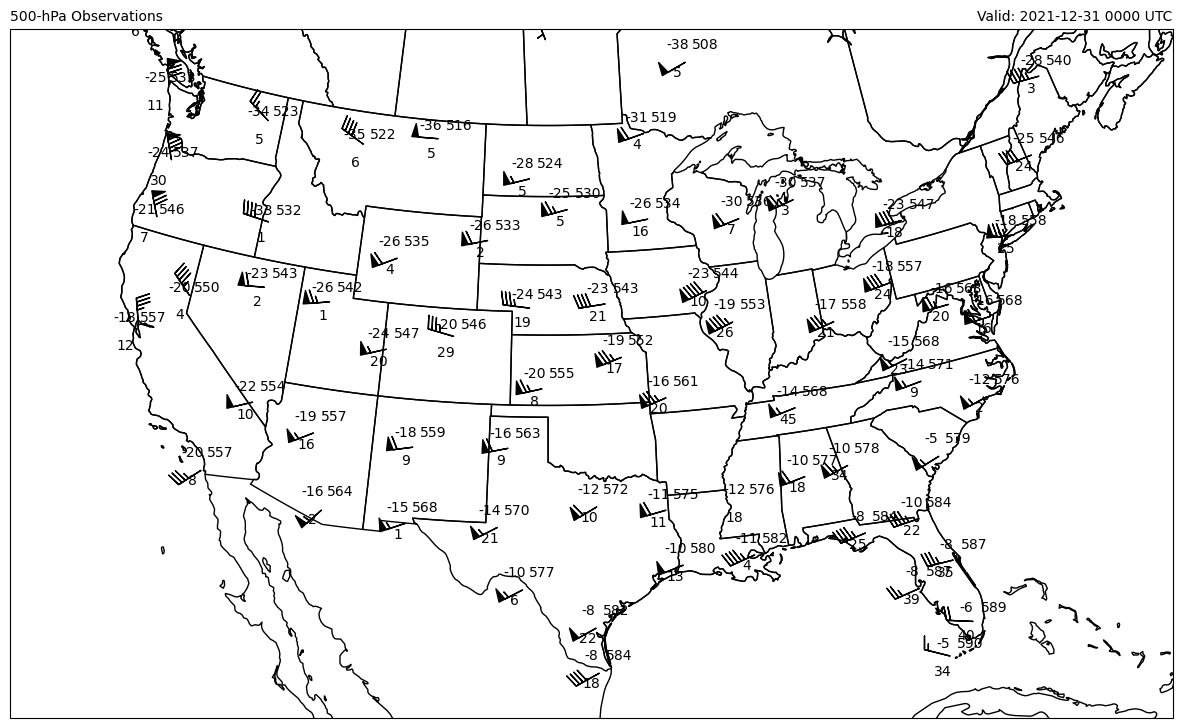

In [9]:
# Set a format specifier for the geoptential height
# This formatter takes a value 9300 -> 930
# Good for 500-hPa and 300-hPa Observations
height_format = lambda v: format(v, '.0f')[:-1]

# Set a format specifier for the geoptential height
# This formatter takes a value 1576 -> 576
# Good for 700-hPa, 850-hPa, and 925-hPa Observations
# height_format = lambda v: format(v, '.0f')[1:]

# Plot desired data
obs = declarative.PlotObs()
obs.data = df
obs.time = date
obs.level = 500 * units.hPa
obs.fields = ['temperature', 'dewpoint_depression', 'height']
obs.locations = ['NW', 'SW', 'NE']
obs.formats = [None, None, height_format]
obs.vector_field = ['u_wind', 'v_wind']

# Panel for plot with Map features
panel = declarative.MapPanel()
panel.layout = (1, 1, 1)
panel.projection = 'lcc'
panel.area = [-124, -72, 24, 50]
panel.layers = ['states', 'coastline']
panel.left_title = f'{obs.level.m}-hPa Observations'
panel.right_title = f'Valid: {date:%Y-%m-%d %H00} UTC'
panel.plots = [obs]

# Bringing it all together
pc = declarative.PanelContainer()
pc.size = (15, 12)
pc.panels = [panel]

#pc.save(f'{obs.level.m}hPa_observations_{date:%Y%m%d%H}.png', dpi=150, bbox_inches='tight')
pc.show()